# Diagnosis of Heart Disease in Cleveland Patients

### Introduction:
Cardiovascular diseases are the world's leading cause of death, killing over 17.9 million people each year. A number of factors are known to contribute to heart diseases, including an individual’s age, cholesterol levels, blood pressure, and many others. With so many factors impacting a patient's cardiac health, it is important to be aware of what sorts of things can increase the risk of future disease, and what physical characteristics are the most indicative of these diseases.

With this in mind, we will answer the following question in this report. Based on a Cleveland patient’s age, cholesterol level and resting blood pressure, what category of heart disease do they have (0: no heart disease to 4: severe heart disease)? To regard the posed question, the Cleveland Heart Disease data set will be used from the UCI Machine Learning Repository. This dataset contains 14 variables relating to heart disease that were measured by doctors. There are 229 observations (rows) in the dataset that will be used for analysis.


## Exploratory Data Analysis

### Importing Libraries

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Reading Data from the web 

In [78]:
# URL dataset comes from
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
# Select predictor and target variable column numbers from the description of the dataset at https://archive.ics.uci.edu/ml/datasets/Heart+Disease
heart_data <- read_delim(url, col_names=FALSE, delim=",") %>% 
    select(X1, X4, X5, X14) %>% 
# Make target variable a factor
    mutate(X14 = as_factor(X14))

# Add column names
colnames(heart_data) <- c("age", "resting_bp", "cholesterol", "disease_presence")

# Split data into training and test set with 75% of data going to the training set
heart_split <- initial_split(heart_data, prop = 0.75, strata = disease_presence) 
heart_train <- training(heart_split) 
# for later use
heart_test <- testing(heart_split)

heart_train

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,resting_bp,cholesterol,disease_presence
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,0
67,160,286,2
67,120,229,1
⋮,⋮,⋮,⋮
57,130,131,3
57,130,236,1
38,138,175,0


### Summary table of the number of observations in each class.

In [67]:
counts_of_disease_presence <- group_by(heart_train, disease_presence) %>%
    summarize(n=n())
counts_of_disease_presence

`summarise()` ungrouping output (override with `.groups` argument)



disease_presence,n
<fct>,<int>
0,124
1,41
2,27
3,27
4,10


### Summary table of our predictor variables showing the min, max, and mean of each of our predictors.

In [70]:
# Select only predictor variables
predictor_vars <- heart_train %>% 
    select(-disease_presence)

# Summarize each of the metrics we are looking for using map_df
mean_summary <- predictor_vars %>% 
    map_df(mean, na.rm=TRUE)
min_summary <- predictor_vars %>% 
    map_df(min, na.rm=TRUE)
max_summary <- predictor_vars %>% 
    map_df(max, na.rm=TRUE)

# Combine predicted summary dataframes together
predictor_summary <- bind_rows(mean_summary, min_summary, max_summary)
# Combine predicted summary dataframe with descriptive row titles
predictor_summary <- bind_cols(c("mean", "min", "max"), predictor_summary)
# Rename column names to match what is in each column
colnames(predictor_summary) = c("Attribute", "age", "resting_bp", "cholesterol")

predictor_summary

New names:
* NA -> ...1



Attribute,age,resting_bp,cholesterol
<chr>,<dbl>,<dbl>,<dbl>
mean,54.04803,131.8734,246.3406
min,29.00000,94.0000,126.0000
max,77.00000,200.0000,417.0000


### Visualizing our Training Data
Here we have created one histogram for each of our predictors showing the distribution of the values in each column.

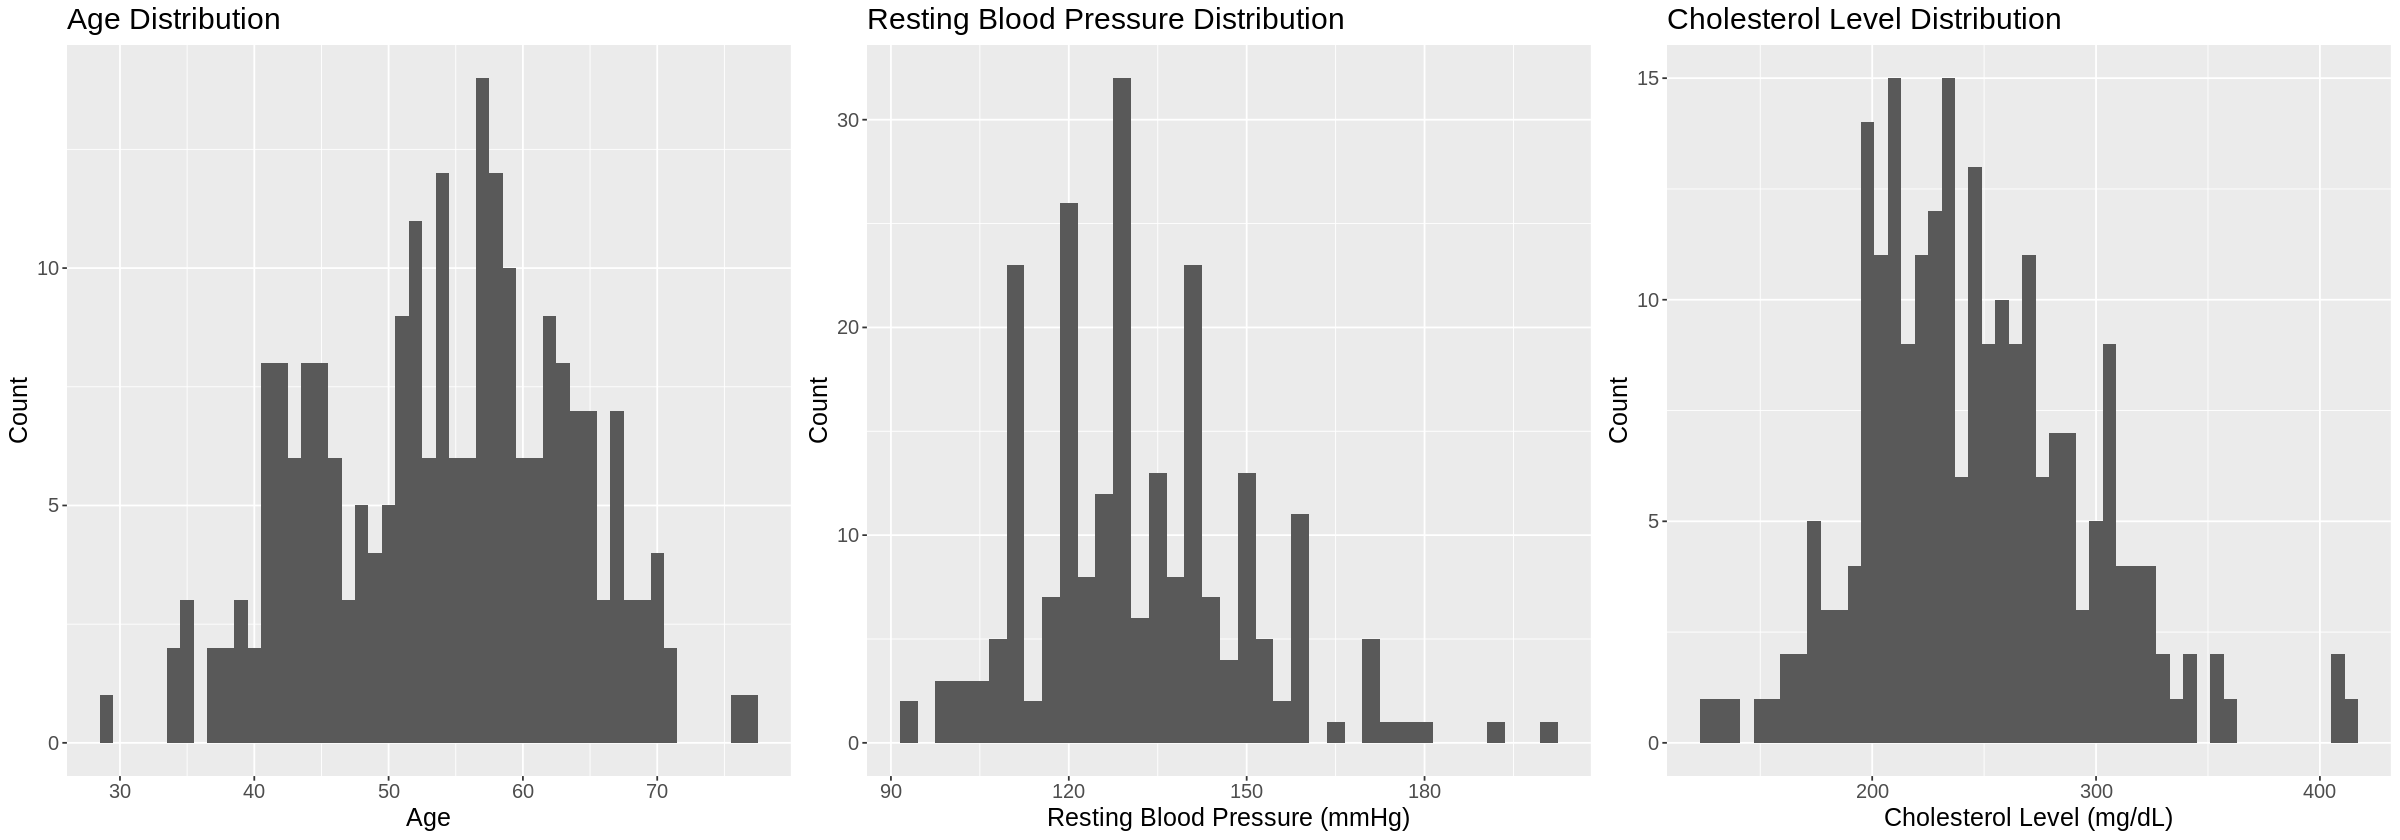

In [77]:
require(gridExtra)
options(repr.plot.height = 7, repr.plot.width = 20)
age_histogram <- ggplot(heart_train, aes(x = age)) +
    geom_histogram(binwidth = 1) +
    xlab("Age") +
    ylab("Count") +
    ggtitle("Age Distribution") +
    theme(text = element_text(size = 15))
resting_bp_histogram <- ggplot(heart_train, aes(x = resting_bp)) +
    geom_histogram(binwidth = 3) +
    xlab("Resting Blood Pressure (mmHg)") +
    ylab("Count") +
    ggtitle("Resting Blood Pressure Distribution") +
    theme(text = element_text(size = 15))
cholesterol_histogram <- ggplot(heart_train, aes(x = cholesterol)) +
    geom_histogram(binwidth = 6) +
    xlab("Cholesterol Level (mg/dL)") +
    ylab("Count") +
    ggtitle("Cholesterol Level Distribution") +
    theme(text = element_text(size = 15))

grid.arrange(age_histogram, resting_bp_histogram, cholesterol_histogram, ncol = 3)

## Methods
From the 14 attributes in the original dataset, we will use 3 predictor variables along with our classification variable: age (in years), cholesterol (chol in mg/dl), resting blood pressure (trestbps in mmHg ), and the predicted variable, heart disease diagnosis (num). Using a classification method, these columns will give the characteristics needed to help categorize individuals' heart conditions. We will be using the K-nearest neighbours classification algorithm to make our predictions after scaling our data in a recipe so each variable is weighted equally. After splitting our data into test and training data, we will make a recipe, classification model, and workflow using cross-validation and tuning to get a better idea of the true accuracy of our model and choose the k-value to maximize this accuracy. To visualize our results, 3 scatter plots of the predicted variable (y-axis) will be plotted against each of the predictor variables (x-axis). This will help us identify patterns between the variables and help us determine which of the predictive variables have the biggest impact on our guiding question.

## Expected outcomes and significance:
We expect that older people with higher blood pressure and higher cholesterol to have higher rates and severity of heart disease. Depending on the accuracy of the model obtained in this investigation, this may reinforce the fact that the presence of heart disease is solidly rooted in the variables used, and will allow us to see how heart disease relates to them. The results of this investigation may inspire those with concerning levels of cholesterol or blood pressure to make changes to their lifestyle habits to improve their health. It could also provide some insight as to exactly how the presence of heart disease relates to these variables and may aid in finding more effective solutions to reduce the risk of heart disease. With the results of this investigation, many more questions may arise. For instance, what other variables does the presence of heart disease depend on, or on which variable, in particular, may the presence of heart disease depend on most heavily?

### References:
<i>Cardiovascular diseases.</i> (2019, June 11). World Health Organization. https://www.who.int/health-topics/cardiovascular-diseases#tab=tab_1 <br>
<i>UCI machine learning repository: Heart disease data set.</i> (n.d.). Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease